In [1]:
import scipy.io
import sys
import csv
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import pandas as pd
import wfdb
from wfdb import processing, Annotation
from tqdm import tqdm
import pickle

In [2]:
filepath = './physionet.org/files/ecg-arrhythmia/1.0.0/WFDBRecords'

In [3]:
waveform = scipy.io.loadmat(filepath+'/07/070/JS06344'+'.mat')['val']

In [4]:
lead12path = './af_challenge_2020/classification-of-12-lead-ecgs-the-physionetcomputing-in-cardiology-challenge-2020-1.0.2/training/cpsc_2018/g1/A0001.mat'

In [5]:
ecg_diagnoses = {
    "164889003": "A",  # atrial fibrillation
    "195080001": "A",  # atrial fibrillation and flutter
    "426749004": "A",  # chronic atrial fibrillation
    "282825002": "A",  # paroxysmal atrial fibrillation
    "314208002": "A",  # rapid atrial fibrillation
    "426783006": "N",  # sinus rhythm
}

In [6]:
def resample(xs, fs, fs_target):
    lx = []
    for chan in range(xs.shape[1]):
        resampled_x, _ = processing.resample_sig(xs[:, chan], fs, fs_target)
        lx.append(resampled_x)

    return np.column_stack(lx)

In [7]:
data_12lead_path = './af_challenge_2020/classification-of-12-lead-ecgs-the-physionetcomputing-in-cardiology-challenge-2020-1.0.2/'

## Level - 0: 1000 samples from georgia, 1: all samples from georgia, 2: all samples
def import_12lead_data(target_freq=300, level=1):
    # Dx_map = pd.read_csv(data_12lead_path + 'Dx_map.csv')
    # Dx_map = Dx_map.set_index('SNOMED CT Code')['Abbreviation'].to_dict()
    # print(Dx_map)

    samples = []

    with open(data_12lead_path + 'RECORDS', 'r') as f:
        for line in f.readlines():
            dir = data_12lead_path + line.rstrip('\n')

            if ('cpsc_2018' not in dir) and level <= 1:
                continue

            for filename in tqdm(os.listdir(dir)):
                if filename[-3:] == 'mat':
                    sample = wfdb.rdsamp(dir + '/' + filename[:-4])

                    diagnoses = [x[4:] for x in sample[1]['comments'] if 'Dx: ' in x]
                    assert len(diagnoses) == 1

                    D = ''
                    if diagnoses[0] in ecg_diagnoses:
                        D = ecg_diagnoses[diagnoses[0]]
                    else:
                        D = 'O'
                        

                    waveform = resample(sample[0], sample[1]['fs'], target_freq)

                    samples.append((waveform, D)) 
            
            if level == 0:
                break

    return samples

def import_balanced_12lead_data():
    pick_path = './af_challenge_2020/balanced.pk'

    if os.path.exists(pick_path):
        with open(pick_path, 'rb') as file:
            return pickle.load(file)
    else:
        data = import_12lead_data(level=2)

        unique_categories = list(set([x[1] for x in data]))

        dictmap = {cat:[x for x in data if x[1] == cat] for cat in unique_categories}

        trim_value = min([len(ls) for ls in dictmap.values()])

        output_data = []
        for ls in dictmap.values():
            output_data += ls[:trim_value]

        with open(pick_path, 'wb') as file:
            pickle.dump(output_data, file)

        return output_data

data = import_balanced_12lead_data()

In [8]:
pd.Series([x[1] for x in data]).value_counts()

O    1106
A    1106
N    1106
Name: count, dtype: int64

In [9]:
waveform = scipy.io.loadmat(lead12path)['val']

In [10]:
waveform.shape

(12, 7500)

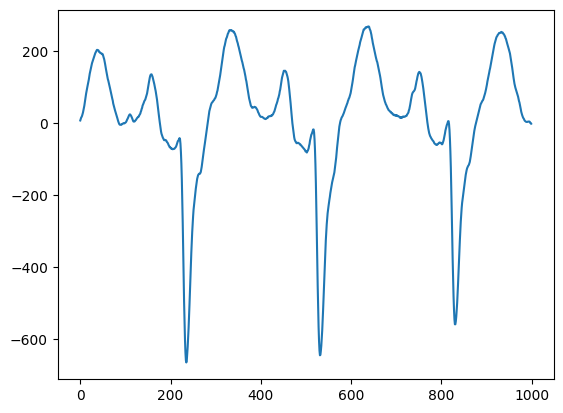

In [11]:
plt.plot(waveform.transpose()[:1000,1])

In [12]:
def plotwave(x, n=1000):
    x = x[0,1000:1500]
    plt.plot(x.reshape(x.shape[1], x.shape[0]))

plotwave(waveform)

IndexError: tuple index out of range